In [1]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [4]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_LTB4-inhib')
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set/')

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(6)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))

um_per_px = 2.2

<AxesSubplot:xlabel='timepoint', ylabel='circle_radius'>

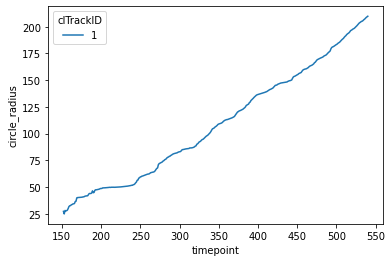

In [5]:
sns.lineplot(data=wave_df, x='timepoint', y='circle_radius', hue='clTrackID')

In [6]:
#Lets select the example wave:
ex_wave_num = 1
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]
start_time = ex_wave_DF.timepoint.min()
pre_wave_time = start_time - 12 #one min prior to wave
end_time = ex_wave_DF.timepoint.max()
post_wave_time = start_time + 60 #three min after wave starts

In [7]:
#Getting a circle from set: 
ex_time = end_time
vmin_set = 200
vmax_set = 1000
border_color = '#B54845'
border_width = 12
crop_buffer = 160

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/2.2 #need to convert back from um to px
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

In [8]:
#Now for the tracks: 
tracks = tracking_df.groupby('track_id')

#get the tracks that arcos says are inside the wave...
track_collect = []
outer_tracks = []
track_min_len = 24

for i, track in tqdm(tracks): 
    if i in ex_arcos_DF.track_id.unique():
        if len(track) > track_min_len:
            track_collect.append(track[track['timepoint'].between(start_time, post_wave_time)])
    else:
        outer_tracks.append(track[track['timepoint'].between(start_time, post_wave_time)])
        
tracks_in_wave = pd.concat(track_collect, ignore_index=True)
tracks_out_wave = pd.concat(outer_tracks, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:04<00:00, 1175.07it/s]


In [9]:
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==end_time].wave_centroid.values[0]
wave_r = ex_wave_DF[ex_wave_DF['timepoint']==end_time].circle_radius.values[0]/2.2 #need to convert back from um to px


In [10]:
#sample_size = 20000
#track_subset = random.sample(list(tracking_df.track_id.unique()),sample_size)

subset_collect = []

for i, track in tqdm(tracking_df.groupby('track_id')):
    #if i in track_subset:
    track = track[track['timepoint'].between(start_time, post_wave_time)]
    if len(track) > 24:
        #Get the time, x, and y points --> Smooth x and y on time... 
        time = track.timepoint.values*5.0
        x_smooth = UnivariateSpline(time, track.x.values, s=10)
        y_smooth = UnivariateSpline(time, track.y.values, s=10)

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([wave_center[0] - coords[i][0], wave_center[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        track['wave_center_distance'] = dist_from_center
        subset_collect.append(track)

subset_tracks = pd.concat(subset_collect, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:14<00:00, 373.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4204/4204 [00:04<00:00, 870.89it/s]


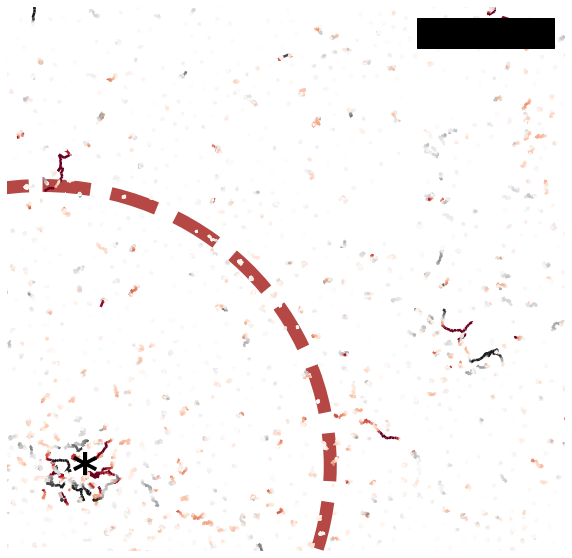

In [29]:
fig, axs = plt.subplots(figsize=(10,10))
#cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

norm = plt.Normalize(-6, 6)
#norm = plt.Normalize(0, 600)
#norm = plt.Normalize(min(subset_tracks.timepoint), max(subset_tracks.timepoint))

for i, track in tqdm(subset_tracks.groupby('track_id')):
    time_pts = track.x.values
    rs = track.y.values
    points = np.array([time_pts, rs]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #chemo_index = track.timepoint.values
    #norm = plt.Normalize(min(chemo_index), max(chemo_index))
    chemo_index = track.radial_velocity.rolling(6).mean()
    
    # Create a continuous norm to map from data points to colors

    lc = LineCollection(segments, cmap='RdGy_r', norm=norm)
    # Set the values used for colormapping
    lc.set_array(chemo_index)
    lc.set_linewidth(2.5)
    line = axs.add_collection(lc)
    
#plt.imshow(raw_tif[post_wave_time, 0,:,:], cmap='Greys_r', vmin=50, vmax=1400)
circle1 = plt.Circle(wave_center, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width+1)
axs.add_patch(circle1)
scalebar = AnchoredSizeBar(axs.transData,
                           100/um_per_px, '',  'upper right', 
                           pad=1,
                           color='black',
                           frameon=False,
                           size_vertical=10)

axs.add_artist(scalebar)
plt.ylim(i_wave_center[1]-crop_buffer,i_wave_center[1]+25)
plt.xlim(i_wave_center[0]-25,i_wave_center[0]+crop_buffer)
axs.axis('off')
plt.text(i_wave_center[1], i_wave_center[0], '*', color='black', fontweight='bold', fontsize=50)
plt.gca().invert_yaxis()
plt.savefig('fig2-supp-BIIL315-tracks-end-of-wave-5min_{}.png'.format(image_num), bbox_inches='tight', dpi=300, transparent=True)